# **Modelo TabTransformer**

In [1]:
import time, os
import numpy as np
import pandas as pd
import random
import torch

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models.tab_transformer.config import TabTransformerConfig
from pytorch_lightning import seed_everything

import matplotlib.pyplot as plt

import torch.optim as optim 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# --- 1) Cargar y preparar ---
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz   = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

df = df[df["CATEGORIA"] != 2].copy()
df = df.drop(columns=["lon","lat","year"], errors="ignore")

clases_ordenadas = sorted(df["CATEGORIA"].unique())
mapa = {old:new for new,old in enumerate(clases_ordenadas)}
df["CATEGORIA"] = df["CATEGORIA"].map(mapa)

feat_cols = [c for c in df.columns if c!="CATEGORIA"]
X = df[feat_cols].values.astype(np.float32)
y = df["CATEGORIA"].values.astype(np.int64)

# --- split + escala (aquí se crean las variables que faltaban) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled  = scaler.transform(X_test).astype(np.float32)

# --- 2) Modelo muy simple estilo “TabTransformer” ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TabTransformer(nn.Module):
    def __init__(self, num_features, num_classes, dim_embedding=64, num_heads=4, num_layers=4):
        super().__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        enc = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.tr = nn.TransformerEncoder(enc, num_layers=num_layers)
        self.cls = nn.Linear(dim_embedding, num_classes)
    def forward(self, x):          # x: [B, F]
        x = self.embedding(x)      # [B, D]
        x = x.unsqueeze(1)         # [B, 1, D]
        x = self.tr(x)             # [B, 1, D]
        x = x.mean(dim=1)          # [B, D]
        return self.cls(x)         # [B, C]

num_features = X_train_scaled.shape[1]
num_classes  = len(np.unique(y))
model = TabTransformer(num_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- 3) TensorDataset + DataLoader ---
train_ds = TensorDataset(
    torch.from_numpy(X_train_scaled), torch.from_numpy(y_train)
)
test_ds  = TensorDataset(
    torch.from_numpy(X_test_scaled),  torch.from_numpy(y_test)
)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# helper para ver accuracy por época
def eval_accuracy(dl):
    model.eval()
    corr, tot = 0, 0
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            corr += (pred == yb).sum().item()
            tot  += yb.size(0)
    model.train()
    return corr / tot

t0 = time.perf_counter()
EPOCH = 1
# --- 4) Entrenamiento ---
model.train()
train_seen = 0
for epoch in range(EPOCH):  # aumenta a 100 si quieres
    running = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)

    # imprime no solo pérdidas: también accuracy en train y test
    if epoch % 1 == 0:
        train_acc = eval_accuracy(train_dl)
        test_acc  = eval_accuracy(test_dl)
        print(f"Epoch {epoch:02d} | Loss: {running/len(train_ds):.4f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
fit_seconds = time.perf_counter() - t0

EPOCHS = max(EPOCH, 1)  # por si acaso
num_train = len(train_dl.dataset)

if num_train > 0:
    ms_per_sample_train = (fit_seconds / (EPOCHS * num_train)) * 1000.0
else:
    ms_per_sample_train = float("nan")

print(f"⏱ Entrenamiento: {fit_seconds:.2f}s | {ms_per_sample_train:.3f} ms/muestra (train)")

# ---- 6) INFERENCIA cronometrada ----
t0 = time.perf_counter()
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds  = logits.argmax(1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(yb.numpy())
pred_seconds = time.perf_counter() - t0

import numpy as np
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

# Tiempo por muestra de INFERENCIA (no depende de EPOCHS)
ms_per_sample_infer = (pred_seconds / len(y_true)) * 1000.0
print(f"⏱ Inferencia: {pred_seconds:.2f}s | {ms_per_sample_infer:.3f} ms/muestra (test)")

Epoch 00 | Loss: 0.5753 | Train Acc: 0.8504 | Test Acc: 0.8529
⏱ Entrenamiento: 3.84s | 0.188 ms/muestra (train)
Test Accuracy (final): 0.8529
⏱ Inferencia: 0.16s | 0.018 ms/muestra (test)


In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# ---- Métricas ----
oa = accuracy_score(y_true, y_pred)
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
cm_row_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_row_percentage = np.nan_to_num(cm_row_percentage)  # handle division by zero

print(f"OA: {oa:.4f}  |  Precisión(macro): {p_macro:.4f}  |  Recall(macro): {r_macro:.4f}  |  F1-macro: {f1_macro:.4f}")

OA: 0.8529  |  Precisión(macro): 0.7773  |  Recall(macro): 0.7075  |  F1-macro: 0.7294


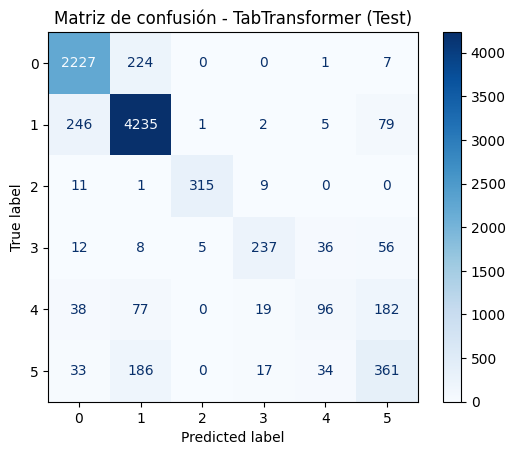

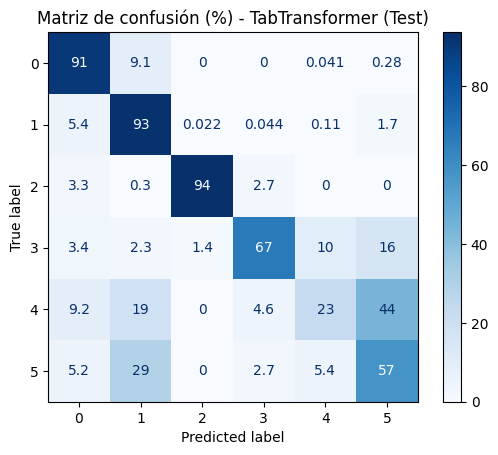

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Matriz de confusión - TabTransformer (Test)")
plt.show()

ConfusionMatrixDisplay(cm_row_percentage).plot(cmap='Blues')
plt.title("Matriz de confusión (%) - TabTransformer (Test)")
plt.show()